# Analysing Traffic Jams across causeway

In [1]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,8))
plt.imshow(plt.imread('../2018-05-15T10:25:28+08:00.jpg'))

In [3]:
import matplotlib.pyplot as plt
import cv2
from math import pi
import numpy as np
import pandas as pd
import os
files = sorted(os.listdir('./4713'))

# data systematically sampled using LTA API. Sampled 1500 images over 2018
# Checking if hour/day/month systematically sampled

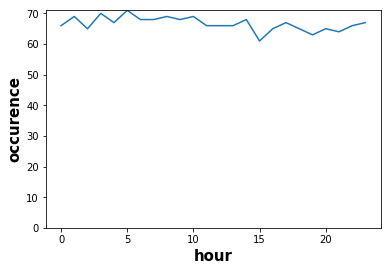

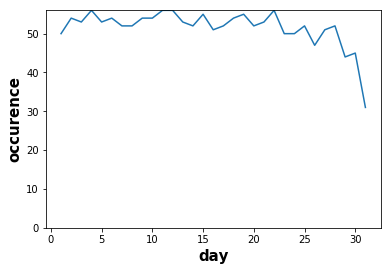

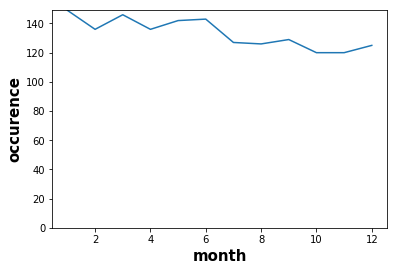

      month  day  hour  min
0         1    1     4   10
200       2   12     0   11
400       3   24    23    7
600       5    8    17   37
800       6   19     4   48
1000      8    5    13   51
1200      9   23    11    3
1400     11   11    10   15


In [4]:
data = pd.DataFrame(files,columns=['filename',])
data['year'] = data['filename'].apply(lambda x : int(x[:4]))
data['month'] = data['filename'].apply(lambda x : int(x.split('-')[1]))
data['day'] = data['filename'].apply(lambda x : int(x.split('-')[2][:2]))
data['hour'] = data['filename'].apply(lambda x : x[11:13]).astype(np.uint32)
data['min'] = data['filename'].apply(lambda x : x[14:16]).astype(np.uint32)
data['sec'] = data['filename'].apply(lambda x : x[17:19]).astype(np.uint32)
data['img'] = data['filename'].apply(lambda x : plt.imread('./4713/'+x).astype(np.uint8))
data['img299'] = data['img'].apply(lambda x : cv2.resize(x,(299,299)))
for i in ['hour','day','month']:
    temp = data.groupby(i).apply(len).reset_index(drop=False)
    plt.plot(temp[i],temp[0])
    plt.xlabel(i,fontsize=15,fontweight='bold')
    plt.ylabel('occurence',fontsize=15,fontweight='bold')
    plt.ylim(0,np.max(temp[0]))
    plt.show()
print (data[['month','day','hour','min',]].iloc[::200])

In [5]:
#pretrained models
import tensorflow as tf
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#jam classifier model
traffic_jam_classifier =  tf.keras.models.load_model('./keras_model.h5')
# load retinanet model
car_detection_model = models.load_model('./resnet50_csv_03.h5', backbone_name='resnet50')
car_detection_model = models.convert_model(car_detection_model)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [6]:
data['jam'] = traffic_jam_classifier.predict(np.stack(data['img299'].values/255,0),batch_size=8)
import gc
gc.collect()

473

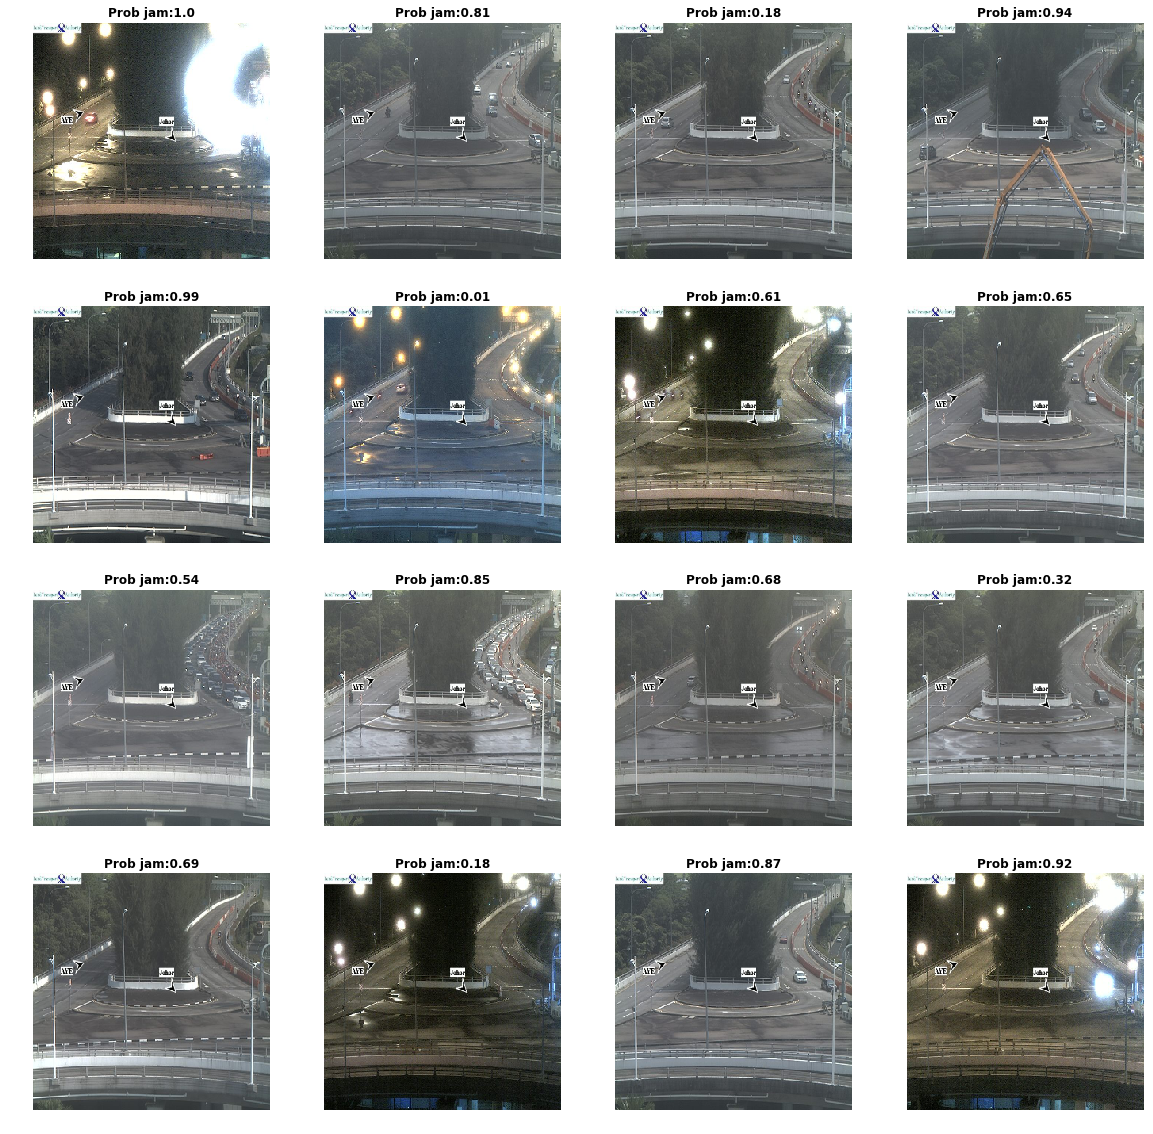

In [7]:
# view predictions if they make sense
fig, ax = plt.subplots(4,4,figsize=(20,20))
temp = data.sample(16).reset_index(drop=True)
counter = 0
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(temp.iloc[counter]['img299'].astype(np.uint8))
        ax[i,j].axis('off')
        ax[i,j].set_title('Prob jam:'+ str(np.round(temp.iloc[counter]['jam'],2)),fontweight='bold')
        counter += 1
plt.show()

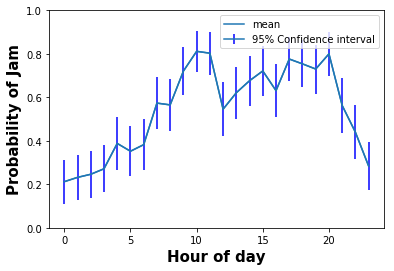

In [8]:
temp = data[['month','day','hour','min','jam']].groupby('hour')['jam'].apply(list).reset_index(drop=False)
temp['median'] = temp['jam'].apply(lambda x : np.mean(np.array(x)>0.5))
temp['95'] = temp['jam'].apply(lambda x : 2*np.std(np.array(x)>0.5,ddof=1)/len(np.array(x))**.5)
temp['5'] = temp['jam'].apply(lambda x : -2*np.std(np.array(x)>0.5,ddof=1)/len(np.array(x))**.5)
#print temp
plt.plot(temp['hour'],temp['median'],label='mean')
plt.xlabel('hour',fontsize=15,fontweight='bold')
plt.ylabel('Median Probability of Jam',fontsize=15,fontweight='bold')
#plt.plot(temp2['hour'],list(map(lambda x : np.percentile(x,15),temp2['jam'].values)),'b')
error = temp[['95','5']].values
#print error
plt.errorbar(temp['hour'],temp['median'],yerr=error.T[0,:],ecolor='b',label='95% Confidence interval')
plt.xlabel('Hour of day')
plt.ylabel('Probability of Jam')
plt.ylim([0,1])
plt.legend()
plt.show()

In [256]:
import datetime 
print (data[['year','month','day']].values[:5])
data['week_day'] = list(map(lambda x : datetime.date(x[0], x[1], x[2]).weekday(),data[['year','month','day']].values))
#data['week_day'] = data['week_day'].map({0:'mon',1:'tue',2:'wed',3:'thur',4:'fri',5:'sat',6:'sun'})
data['week_day'] = data['week_day'].map({0:'wk_day',1:'wk_day',2:'wk_day',3:'wk_day',4:'fri',5:'sat',6:'sun'})

[[2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    2]]


In [12]:
data[['filename', 'year', 'month', 'day','week_day', 'hour', 'min', 'sec', 'jam', 'num_car']].to_csv('results.csv',index=0)

In [241]:
interval = 1
data['hour2'] = (data['hour']//interval)*interval + (interval*1./2)


In [242]:
traffic_day = data.groupby(['week_day','hour2'])['num_car'].apply(lambda x : list(map(lambda x: np.round(x,2),(np.mean(x==50),np.std(x==50,ddof=1)/len(x)**.5))))

In [243]:
traffic_day = traffic_day.reset_index(drop=False)

[[2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    2]]
  week_day  hour2               jam
0      fri    1.0  [0.21, 0.19, 19]
1      fri    3.0  [0.37, 0.23, 19]
2      fri    5.0  [0.18, 0.19, 17]
3      fri    7.0  [0.45, 0.23, 20]
4      fri    9.0  [0.67, 0.23, 18]


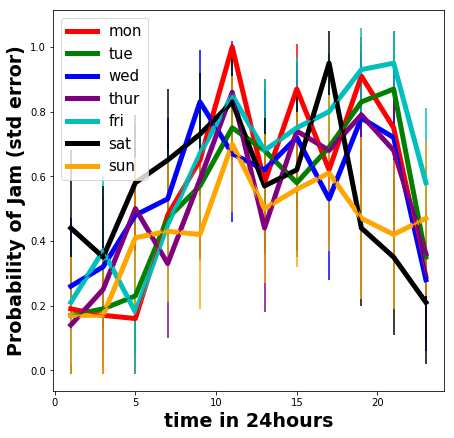

In [260]:
import datetime 
print (data[['year','month','day']].values[:5])
data['week_day'] = list(map(lambda x : datetime.date(x[0], x[1], x[2]).weekday(),data[['year','month','day']].values))
data['week_day'] = data['week_day'].map({0:'mon',1:'tue',2:'wed',3:'thur',4:'fri',5:'sat',6:'sun'})
#data['week_day'] = data['week_day'].map({0:'wk_day',1:'wk_day',2:'wk_day',3:'wk_day',4:'fri',5:'sat',6:'sun'})
interval = 2
data['hour2'] = (data['hour']//interval)*interval + (interval*1./2)
feat = 'jam'
traffic_day = data.groupby(['week_day','hour2'])[feat].apply(lambda x : list(map(lambda x: np.round(x,2),(np.mean(np.array(x)>0.5),2*np.std(np.array(x)>0.5,ddof=1)/len(x)**.5,len(x)))))
traffic_day = traffic_day.reset_index(drop=False)
print (traffic_day.head())
counter= 0
col = ['r','g','b','purple','c','k','orange']
fig = plt.subplots(1,1,figsize=(7,7))
for i in pd.unique(data.week_day)[:]:
    temp = traffic_day[traffic_day['week_day']==i]
    plt.errorbar(temp['hour2'],temp[feat].apply(lambda x:x[0]),
                 yerr=temp[feat].apply(lambda x:x[1]),label=None,color=col[counter])
    plt.plot(temp['hour2'],temp[feat].apply(lambda x:x[0]),label=i,linewidth=5,color=col[counter])
    counter += 1
    plt.xlabel('time in 24hours',fontsize=19,fontweight='bold')
    plt.ylabel("Probability of Jam (std error)",fontsize=19,fontweight='bold')
    plt.legend(fontsize=15)
plt.show()

[[2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    1]
 [2018    1    2]]
  week_day  hour2               jam
0      fri    1.0  [0.27, 0.07, 19]
1      fri    3.0  [0.37, 0.06, 19]
2      fri    5.0  [0.29, 0.08, 17]
3      fri    7.0  [0.45, 0.08, 20]
4      fri    9.0  [0.65, 0.07, 18]


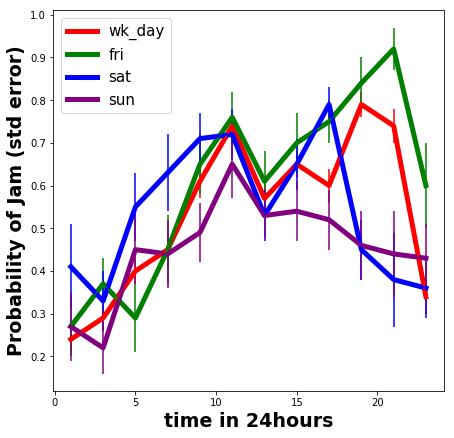

In [264]:
import datetime 
print (data[['year','month','day']].values[:5])
data['week_day'] = list(map(lambda x : datetime.date(x[0], x[1], x[2]).weekday(),data[['year','month','day']].values))
#data['week_day'] = data['week_day'].map({0:'mon',1:'tue',2:'wed',3:'thur',4:'fri',5:'sat',6:'sun'})
data['week_day'] = data['week_day'].map({0:'wk_day',1:'wk_day',2:'wk_day',3:'wk_day',4:'fri',5:'sat',6:'sun'})
interval = 2
data['hour2'] = (data['hour']//interval)*interval + (interval*1./2)
feat = 'jam'
traffic_day = data.groupby(['week_day','hour2'])[feat].apply(lambda x : list(map(lambda x: np.round(x,2),(np.mean(x),np.std(x,ddof=1)/len(x)**.5,len(x)))))
traffic_day = traffic_day.reset_index(drop=False)
print (traffic_day.head())
counter= 0
col = ['r','g','b','purple','c','k','orange']
fig = plt.subplots(1,1,figsize=(7,7))
for i in pd.unique(data['week_day'])[:]:
    temp = traffic_day[traffic_day['week_day']==i]
    plt.errorbar(temp['hour2'],temp[feat].apply(lambda x:x[0]),
                 yerr=temp[feat].apply(lambda x:x[1]),label=None,color=col[counter])
    plt.plot(temp['hour2'],temp[feat].apply(lambda x:x[0]),label=i,linewidth=5,color=col[counter])
    counter += 1
    plt.xlabel('time in 24hours',fontsize=19,fontweight='bold')
    plt.ylabel("Probability of Jam (std error)",fontsize=19,fontweight='bold')
    plt.legend(fontsize=15)
plt.show()

# Shapley values calculation

In [173]:
all_img = np.stack(data[(data['jam']>0.30) & (data['jam']<0.70)]['img299'],0)
def shapley(img):
#if True:
    X= np.stack([np.array([range(299),]*299),np.array([range(299),]*299).T],-1)/60
    X=X[:,:,0]+X[:,:,1]*6
    Y=np.ones(((2352+49),299,299)).astype(np.uint8)
    gc.collect()
    counter = 0
    coef = np.zeros((2352+49,36))
    for i in range(36):
        Y[counter] = (X==i)
        coef[counter,i]=1
        coef[counter,i]=1
        counter += 1
        for j in range(36):
            if j!=i :
                if True:
                    Y[counter] = (X==i)+(X==j)
                    coef[counter,i]=1
                    coef[counter,j]=1
                    counter += 1
    Y = np.concatenate([Y[:counter],1-Y[:counter]],0).astype(np.uint8)
    coef = np.concatenate([coef[:counter],1-coef[:counter]],0)

    Z =np.expand_dims(img.astype(np.uint8),0) * np.expand_dims(Y,-1) + (1-np.expand_dims(Y,-1))*all_img[np.random.choice(range(len(all_img)),len(Y))]
    gc.collect()
    #die
    preds = traffic_jam_classifier.predict(Z,batch_size=40)
    del Z
    gc.collect()
    shap = np.linalg.lstsq(coef,preds)
    shap_pic = np.reshape(map(lambda x : shap[0][x], np.reshape(X,299*299)),(299,299))
    return shap_pic

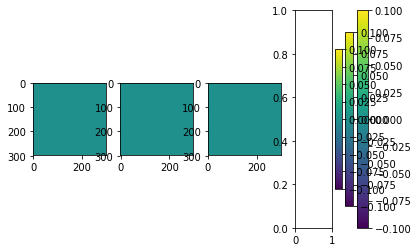

/home/leexiongan/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


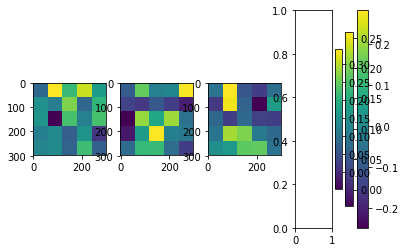

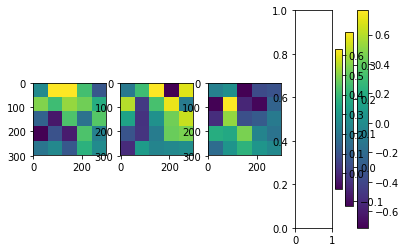

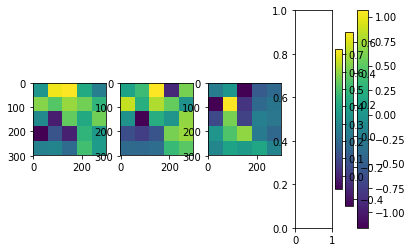

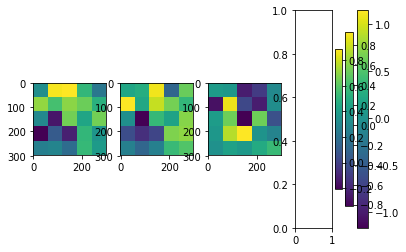

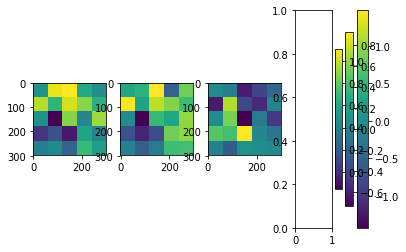

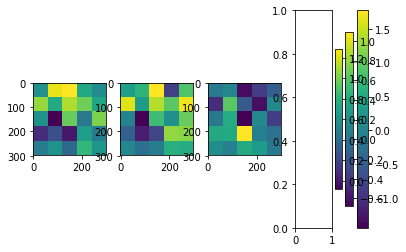

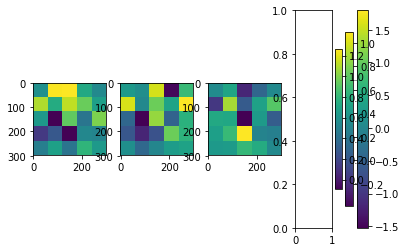

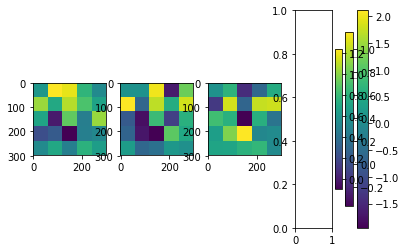

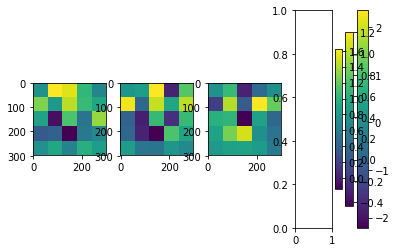

In [174]:
no = np.zeros((299,299))
maybe = np.zeros((299,299)) 
yes = np.zeros((299,299))
n,m,y = 0,0,0
for i in range(0,len(data),16):
    if i%160==0:
        fig,ax =plt.subplots(1,4)
        a= ax[0].imshow(no)
        plt.colorbar(a)
        a=ax[1].imshow(maybe)
        plt.colorbar(a)
        a=ax[2].imshow(yes)
        plt.colorbar(a)
        plt.show()
        
    img = data.loc[i,'img299']
    temp = shapley(img)
    gc.collect()
    if data.loc[i,'jam'] <= 0.25 :
        n += 1
        no += temp
    elif data.loc[i,'jam'] >=0.75 :
        y += 1
        yes += temp
    else:
        m += 1
        maybe += temp


        


# visualize object detection

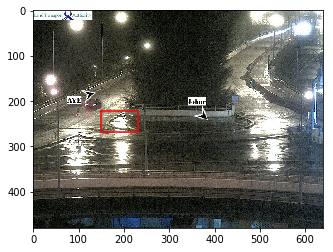

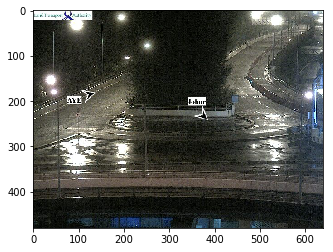

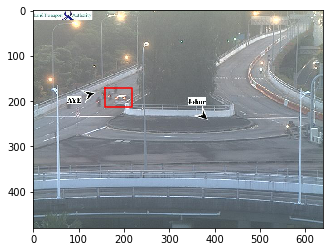

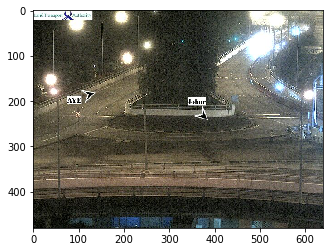

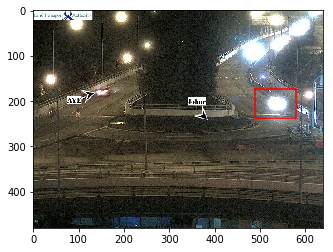

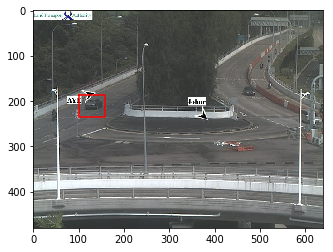

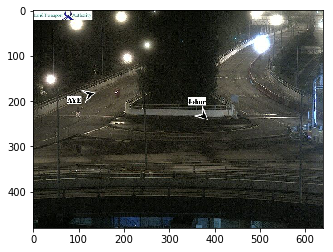

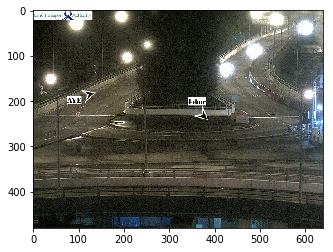

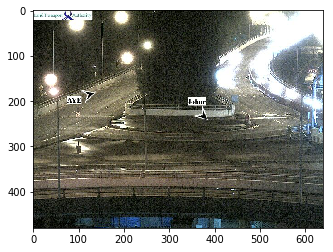

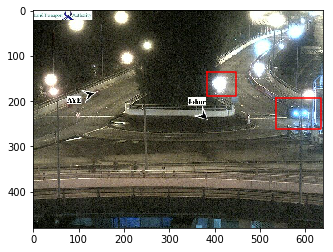

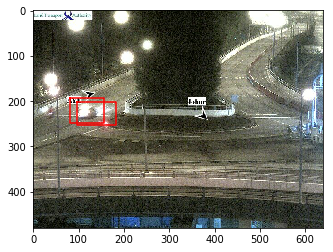

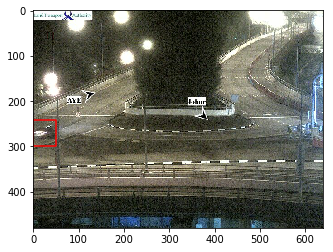

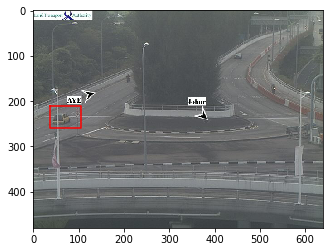

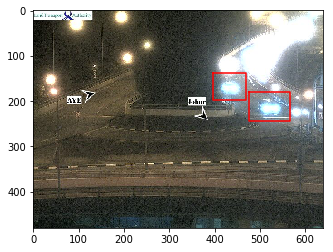

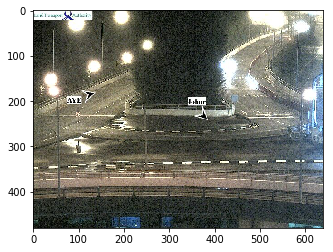

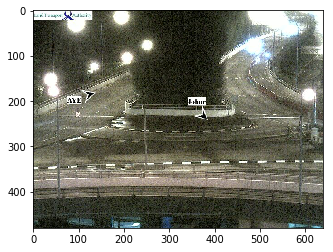

In [176]:
def draw_boxes(img,boxes,scores,labels):
    plt.imshow(img)
    for i1,i2,i3,i4 in boxes[0,scores[0,:]>0.15]:
        plt.plot([i1,i3,i3,i1,i1],[i2,i2,i4,i4,i2],'r');
    plt.show()
temp = []
for i in range(len(data)):
    if data.iloc[i]['jam'] > 0.5:
        temp += [50,]
    else:
        img = data.iloc[i]['img']
        boxes, scores, labels = car_detection_model.predict_on_batch(np.expand_dims(img, axis=0))
        if data.iloc[i]['jam'] < 0.5 and i%50 ==0:
            draw_boxes(img=img.astype(np.uint8),boxes=boxes,scores=scores,labels=labels)
        cars = boxes[0,scores[0,:]>0.15]
        temp += [len(cars[cars[:,0]>400,]),] #get cars in right side, towards tuas
data['num_car'] = temp

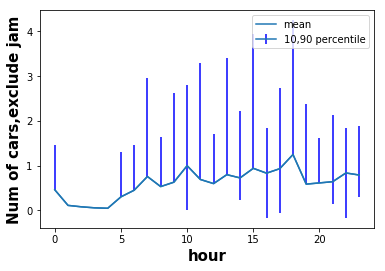

In [221]:
temp = data[data.num_car<50][['month','day','hour','min','num_car']].groupby('hour')['num_car'].apply(list).reset_index(drop=False)
temp['mean'] = temp['num_car'].apply(lambda x : np.mean(x))
temp['75'] = temp['num_car'].apply(lambda x : np.percentile(x,90)-np.median(x))
temp['25'] = temp['num_car'].apply(lambda x : -np.percentile(x,10)+np.median(x))
plt.plot(temp['hour'],temp['mean'],label='mean')
#print (temp)
plt.xlabel('hour',fontsize=15,fontweight='bold')
plt.ylabel('Num of cars,exclude jam',fontsize=15,fontweight='bold')
#plt.plot(temp2['hour'],list(map(lambda x : np.percentile(x,15),temp2['jam'].values)),'b')
error = temp[['25','75']].values
plt.errorbar(temp['hour'],temp['mean'],yerr=error.T,ecolor='b',label='10,90 percentile')
plt.legend()
plt.show()

In [ ]:
temp

In [ ]:
plt.errorbar(temp['hour'],temp['num_car'].apply(lambda x:x[0]),yerr=temp['num_car'].apply(lambda x:x[1]))